# NBA MVP Prediction

## Appending the csv files to create the Dataset 

In [1]:
import pandas as pd
import pathlib
import random as rd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import time
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.neighbors import BallTree
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier
# from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn import tree

from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

In [2]:
nba_dataset = pd.DataFrame()

for season in np.arange(1981,2021,1):
    df = pd.read_csv(f'./data/{season}_std.csv', low_memory=False)    
    nba_dataset = nba_dataset.append(df)

display(nba_dataset)
display(nba_dataset.info())

Player Pos  Age   G    MP   FG   FGA    FG%   3P  3PA  ...  \
0    Kareem Abdul-Jabbar   C   33  80  2976  836  1457  0.574    0    1  ...   
1          Tom Abernethy  SF   26  39   298   25    59  0.424    0    1  ...   
2            Alvan Adams   C   26  75  2054  458   870  0.526    0    0  ...   
3         Darrell Allums  PF   22  22   276   23    67  0.343    0    1  ...   
4         Tiny Archibald  PG   32  80  2820  382   766  0.499    0    9  ...   
..                   ...  ..  ...  ..   ...  ...   ...    ...  ...  ...  ...   
524           Trae Young  PG   21  60  2120  546  1249  0.437  205  568  ...   
525          Cody Zeller   C   27  58  1341  251   479  0.524   18   75  ...   
526         Tyler Zeller   C   30   2     4    1     4  0.250    0    0  ...   
527           Ante Žižić   C   23  22   221   41    72  0.569    0    0  ...   
528          Ivica Zubac   C   22  72  1326  236   385  0.613    0    2  ...   

       WS  WS/48  OBPM  DBPM   BPM  VORP  First  Share     Status  Season  
0    14.3  0.230   4.7   1.4   6.1   6.1      8  0.414  Candidate    1981  
1     0.4  0.062  -2.2  -0.4  -2.6   0.0      0  0.000        OOR    1981  
2     7.7  0.180   2.5   2.6   5.1   3.7      0  0.000        OOR    1981  
3    -0.3 -0.054  -5.5  -0.1  -5.6  -0.3      0  0.000        OOR    1981  
4     6.9  0.118   0.9  -1.0  -0.1   1.4      0  0.046  Candidate    1981  
..    ...    ...   ...   ...   ...   ...    ...    ...        ...     ...  
524   5.9  0.133   6.2  -2.3   3.9   3.1      0  0.000        OOR    2020  
525   3.6  0.129   0.2  -0.8  -0.6   0.5      0  0.000        OOR    2020  
526   0.0 -0.075  -0.3 -22.1 -22.4   0.0      0  0.000        OOR    2020  
527   0.5  0.106  -1.7  -1.5  -3.2  -0.1      0  0.000        OOR    2020  
528   6.6  0.241   1.9   0.8   2.8   1.6      0  0.000        OOR    2020  

[16852 rows x 51 columns]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16852 entries, 0 to 528
Data columns (total 51 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Player  16852 non-null  object 
 1   Pos     16852 non-null  object 
 2   Age     16852 non-null  int64  
 3   G       16852 non-null  int64  
 4   MP      16852 non-null  int64  
 5   FG      16852 non-null  int64  
 6   FGA     16852 non-null  int64  
 7   FG%     16852 non-null  float64
 8   3P      16852 non-null  int64  
 9   3PA     16852 non-null  int64  
 10  3P%     16852 non-null  float64
 11  2P      16852 non-null  int64  
 12  2PA     16852 non-null  int64  
 13  2P%     16852 non-null  float64
 14  eFG%    16852 non-null  float64
 15  FT      16852 non-null  int64  
 16  FTA     16852 non-null  int64  
 17  FT%     16852 non-null  float64
 18  ORB     16852 non-null  int64  
 19  DRB     16852 non-null  int64  
 20  TRB     16852 non-null  int64  
 21  AST     16852 non-null  int64  
 22  

None

Way too many features, we need to remove some of them.

## Feature Removing

In [3]:
cols = ['G','MP','FG','FG%','3P','2P','FT','TRB','DRB%','ORB%','OWS','DWS','WS/48','OBPM','DBPM','First']
print(f"Removing {len(cols)} features.")
nba_dataset = nba_dataset.drop(columns=cols)

Removing 16 features.


## Feature Analysis

<AxesSubplot:>

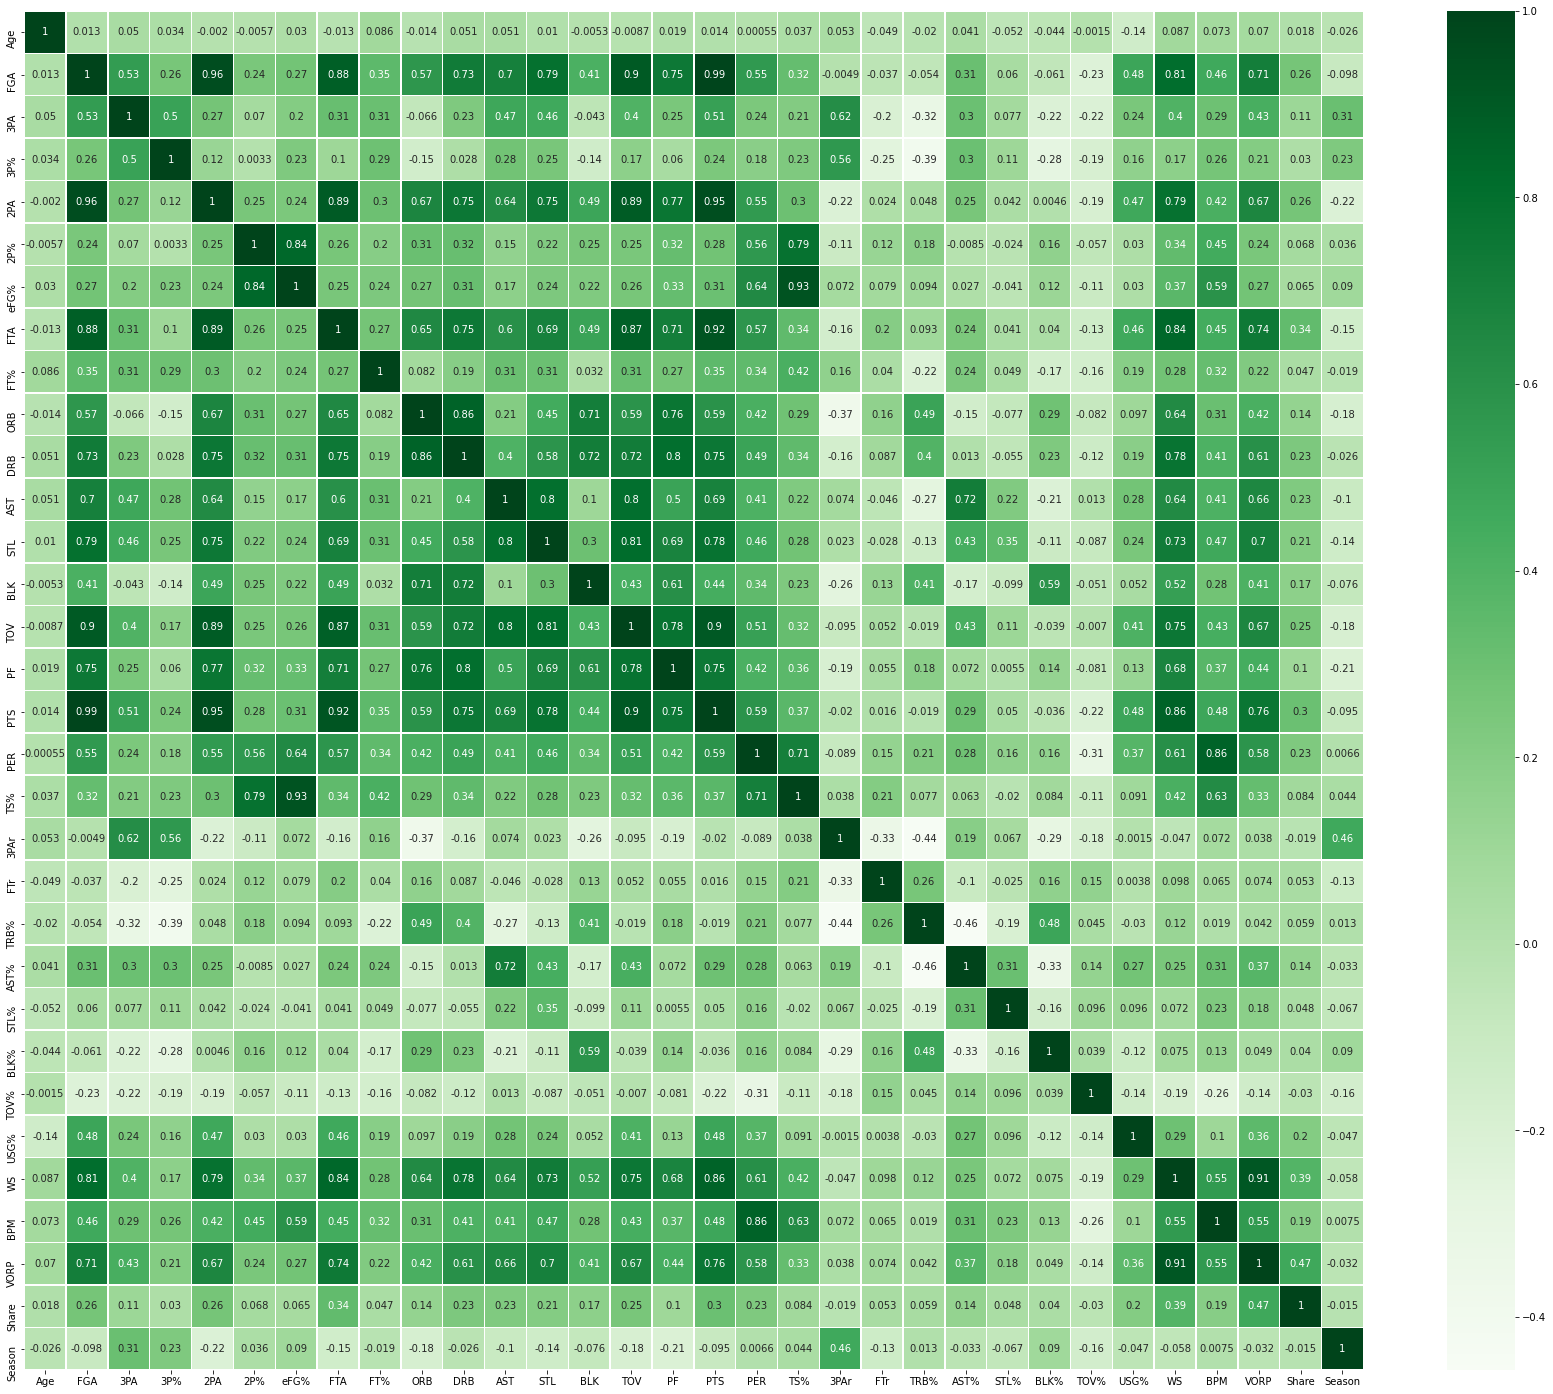

In [4]:
plt.figure(figsize=(30, 25))
sns.heatmap(nba_dataset.corr(), annot=True, cmap='Greens', linewidths=0.5)

I'm gonna keep some features just for further analysis. Once they are not usefull anymore I'll take them out.

## Outlier Analysis

### Functions Definition

In [5]:
def limit_calc(column):
    q1 = column.quantile(0.25)
    q3 = column.quantile(0.75)
    amplitude = q3 - q1
    return q1 - 1.5 * amplitude, q3 + 1.5 * amplitude

In [6]:
def boxplot(column):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(15, 5)
    sns.boxplot(x=column, ax=ax1)
    ax2.set_xlim(limit_calc(column))
    sns.boxplot(x=column, ax=ax2)
    
def histogram(column,color=None):
    plt.figure(figsize=(15, 5))
    sns.histplot(column,color=color)

def bar_chart(column):  
    plt.figure(figsize=(15, 5))
    ax = sns.barplot(x=column.value_counts().index, y=column.value_counts())
    ax.set_xlim(limit_calc(column))

### 3-Point Field Goal Percentage

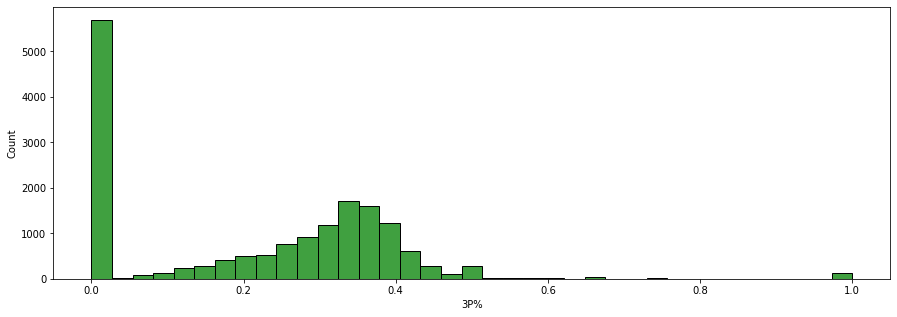

In [7]:
histogram(nba_dataset['3P%'],"Green")

Probably a fews guys had 1 3-pt attempt and managed to score. Those sharpshooters with 100% accuracy gonna be taken out.

Besides that, I gave 3 conditions to keep a player in the Dataset.
<ol>
    <li>Players within the margin: 0% ~ 60% </li>
    <li>Players with more than 60% accuracy can be counted if they tried at least 50 shoots in the season</li>
    <li>Kept the MVP and Candidates regardless their accuracy  </li>  
</ol>

In [8]:
min_val = 0.0
max_val = 0.6

df_size = nba_dataset.shape[0]
nba_dataset = nba_dataset.loc[((nba_dataset['3P%'] >= min_val) & (nba_dataset['3P%'] <= max_val)) 
                              | (nba_dataset['3P%'] > max_val) & (nba_dataset['3PA'] >= 50)
                              | (nba_dataset['Status'] != 'OOR'), :]
removed_rows = df_size - nba_dataset.shape[0]
print('{} rows removed'.format(removed_rows))

193 rows removed


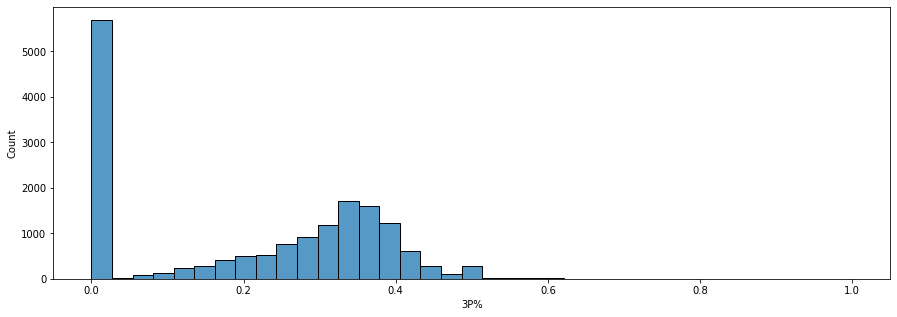

In [9]:
histogram(nba_dataset['3P%'])

### 2-Point Field Goal Percentage

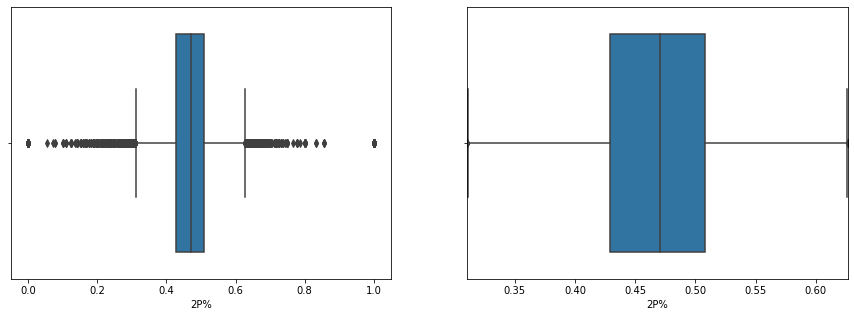

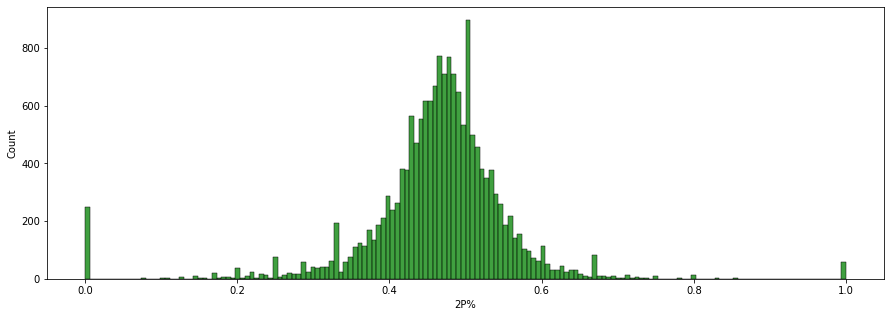

In [10]:
boxplot(nba_dataset['2P%'])
histogram(nba_dataset['2P%'],"Green")

Here again, some bench warmers are generating a few outliers.

The same 3 conditions will be repeated.<br> 
Here we gonna use a quantile (25% - 75%) calculation for the margins and we will consider 250 attempts to validate a outlier accuracy.

In [11]:
min_val, max_val = limit_calc(nba_dataset['2P%'])

df_size = nba_dataset.shape[0]
nba_dataset = nba_dataset.loc[((nba_dataset['2P%'] >= min_val) & (nba_dataset['2P%'] <= max_val)) 
                              | (nba_dataset['2P%'] > max_val) & (nba_dataset['2PA'] >= 250)
                              | (nba_dataset['Status'] != 'OOR'), :]
removed_rows = df_size - nba_dataset.shape[0]
print('{} rows removed'.format(removed_rows))

1039 rows removed


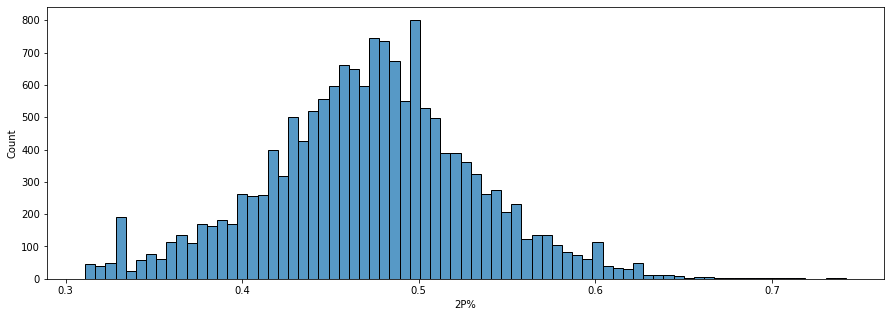

In [12]:
histogram(nba_dataset['2P%'])

We can see that there's a few guys under 40% and over 65% that may be outliers, let's check.

### FT% : Free Throw Percentage

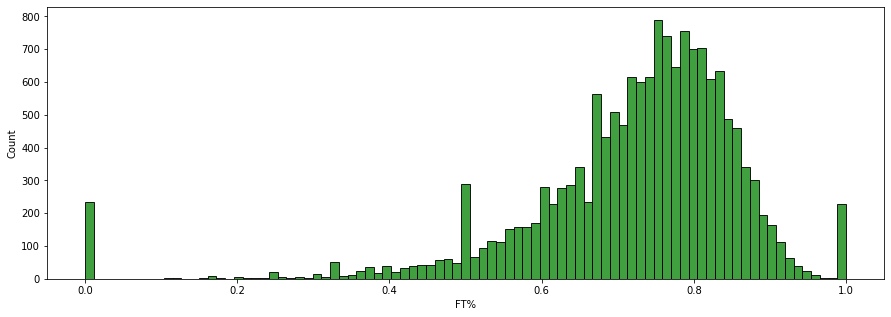

In [13]:
histogram(nba_dataset['FT%'],"Green")

It seems that too many guys had 0% or 100% accuracy. Again, weird numbers.

Gonna treat that, by taking the mean of Free Throw Attempts in count.

In [14]:
print(f"FTA mean: {nba_dataset['FTA'].mean():.0F}")

FTA mean: 146


So let's consider one third of the FTA mean (50 attempts) as the margin and see what happens.

In [15]:
df_size = nba_dataset.shape[0]
nba_dataset = nba_dataset.loc[(nba_dataset['FTA'] >= 50)
                              | (nba_dataset['Status'] != 'OOR'), :]
removed_rows = df_size - nba_dataset.shape[0]
print('{} rows removed'.format(removed_rows))

4671 rows removed


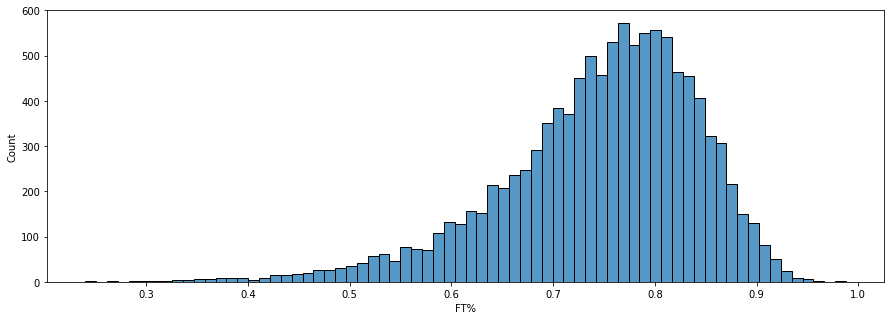

In [16]:
histogram(nba_dataset['FT%'])

#### Fun Fact Section

If you are wondering who are the guys below 35% free throw accuracy with 50 or more attempts, here are the nominees: 

In [17]:
dfloosers = nba_dataset.loc[(nba_dataset['FTA'] >= 50)
                        & (nba_dataset['FT%'] <= 0.35), ['Player','Pos','FTA','FT%','Season']]

display(dfloosers.sort_values(by=['FT%','FTA'], ascending=[True,False]))

Player Pos  FTA    FT%  Season
313       Larry Smith  PF   50  0.240    1991
323    Olden Polynice   C   65  0.262    2001
128       Joey Dorsey  PF   83  0.289    2015
292       Ian Mahinmi   C  102  0.304    2015
284       Larry Smith  PF   58  0.310    1989
322    Olden Polynice   C   90  0.311    2000
86       Chris Dudley  PF  182  0.319    1990
51         Josh Boone  PF   58  0.328    2010
192     Steven Hunter   C   69  0.333    2004
110     DeSagana Diop   C   66  0.333    2009
416       Ben Wallace   C   57  0.333    2011
414       Ben Wallace   C  238  0.336    2001
65        Kwame Brown   C   98  0.337    2010
261     Eric Montross   C   62  0.339    1997
445        Jan Veselý  PF   56  0.339    2014
411  Lorenzo Williams   C   70  0.343    1996
55       Andrew Bogut   C   64  0.344    2014

A few famous names here. Congrats to the Wizards on drafting Kwame Brown as a first pick.

I think the ones with more than 95% should also have their names listed, so here it goes:

In [18]:
dfwow = nba_dataset.loc[(nba_dataset['FTA'] >= 50)
                        & (nba_dataset['FT%'] >= 0.95), ['Player','Pos','FTA','FT%','Season']]

display(dfwow.sort_values(by=['FT%','FTA'], ascending=[False,False]))

Player Pos  FTA    FT%  Season
50      Terrell Brandon  PG   84  0.988    2002
73        José Calderón  PG  154  0.981    2009
201       Calvin Murphy  PG  215  0.958    1981
1    Mahmoud Abdul-Rauf  PG  229  0.956    1994
9             Ray Allen  SG  249  0.952    2009
271          Mark Price  PG   62  0.952    1991
15        Ryan Anderson  PF   62  0.952    2014
178       Jeff Hornacek  SG  180  0.950    2000

Now that the hard work is done, we can take out the attempts features.

In [19]:
nba_dataset = nba_dataset.drop(columns=['3PA','2PA','FTA','FGA','3PAr','FTr'])
display(nba_dataset)

Player Pos  Age    3P%    2P%   eFG%    FT%  ORB  DRB  AST  \
0    Kareem Abdul-Jabbar   C   33  0.000  0.574  0.574  0.766  197  624  272   
2            Alvan Adams   C   26  0.000  0.526  0.526  0.768  157  389  344   
4         Tiny Archibald  PG   32  0.000  0.505  0.499  0.816   36  140  618   
6           James Bailey  PF   23  0.500  0.499  0.500  0.709  192  415   98   
7           Greg Ballard  SF   26  0.219  0.470  0.466  0.847  167  413  195   
..                   ...  ..  ...    ...    ...    ...    ...  ...  ...  ...   
521         Delon Wright  PG   27  0.370  0.504  0.519  0.770   70  210  244   
523       Thaddeus Young  PF   31  0.356  0.501  0.513  0.583   94  221  117   
524           Trae Young  PG   21  0.361  0.501  0.519  0.860   32  223  560   
525          Cody Zeller   C   27  0.240  0.577  0.543  0.682  160  251   88   
528          Ivica Zubac   C   22  0.000  0.616  0.613  0.747  197  346   82   

     ...  STL%  BLK%  TOV%  USG%    WS  BPM  VORP  Share     Status  Season  
0    ...   0.9   4.0  12.8  26.3  14.3  6.1   6.1  0.414  Candidate    1981  
2    ...   2.4   1.9  18.7  23.0   7.7  5.1   3.7  0.000        OOR    1981  
4    ...   1.3   0.4  21.8  17.5   6.9 -0.1   1.4  0.046  Candidate    1981  
6    ...   1.4   3.1  17.3  20.3   4.9 -1.1   0.6  0.000        OOR    1981  
7    ...   2.1   0.8   8.4  21.4   6.9  2.2   2.8  0.000        OOR    1981  
..   ...   ...   ...   ...   ...   ...  ...   ...    ...        ...     ...  
521  ...   2.6   1.2  13.8  14.4   4.4  1.9   1.5  0.000        OOR    2020  
523  ...   2.8   1.4  13.9  19.7   1.9 -1.2   0.3  0.000        OOR    2020  
524  ...   1.4   0.3  16.2  34.9   5.9  3.9   3.1  0.000        OOR    2020  
525  ...   1.5   1.7  11.9  20.8   3.6 -0.6   0.5  0.000        OOR    2020  
528  ...   0.6   4.4  11.8  16.4   6.6  2.8   1.6  0.000        OOR    2020  

[10949 rows x 29 columns]

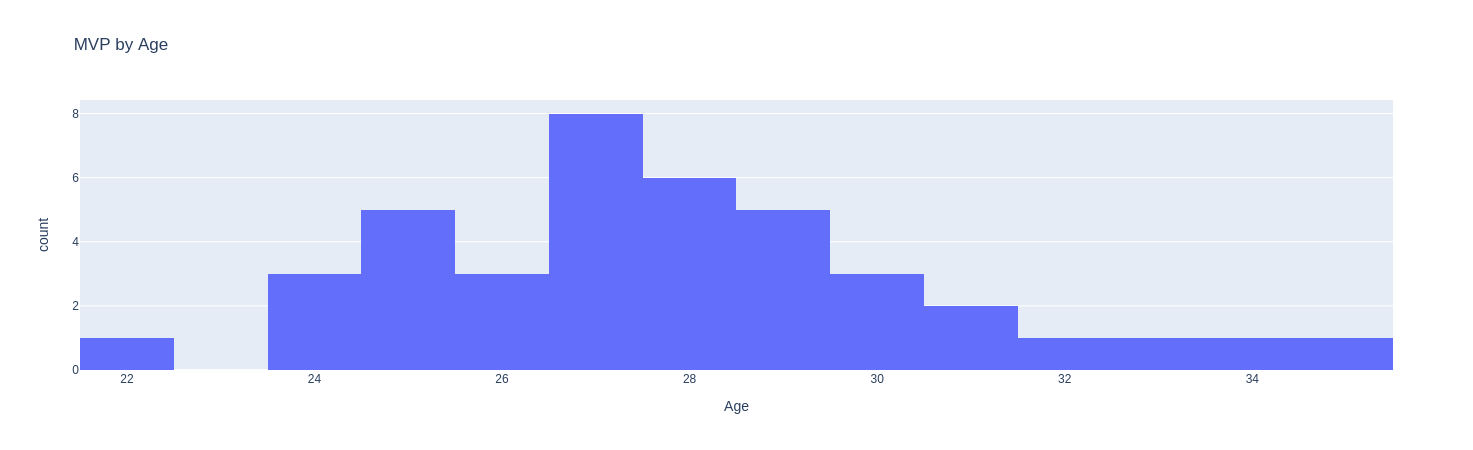

In [20]:
list_b = nba_dataset.loc[(nba_dataset['Status'] == 'MVP'),['Age']]
list_b = list(list_b['Age'].unique())
max_b = max(list_b) + 1
min_b = min(list_b)
bins_to_use = max_b - min_b

fig = px.histogram(nba_dataset.loc[(nba_dataset['Status'] == 'MVP')], x='Age',title='MVP by Age',nbins=int(bins_to_use))
fig.show()

We have **35/40 (87,5%)** between 24 and 31 years and **22/40 ()** between 26 and 29 years.

**Note that these are not the players age when they received the prize. See the glossary.**

In [21]:
dfmvp = nba_dataset.loc[(nba_dataset['Status'] == 'MVP'), :]
dfmvp = dfmvp[['Player','Age']]

display(dfmvp.sort_values(by='Age', ascending=True))

Player  Age
355           Derrick Rose   22
145         Michael Jordan   24
207           LeBron James   24
17   Giannis Antetokounmpo   24
12   Giannis Antetokounmpo   25
133           Kevin Durant   25
221           LeBron James   25
120             Tim Duncan   25
185          Allen Iverson   25
186           Moses Malone   26
111          Stephen Curry   26
108             Tim Duncan   26
104          Stephen Curry   27
232           LeBron James   27
142          Kevin Garnett   27
293       Shaquille O'Neal   27
177           Moses Malone   27
174         Michael Jordan   27
15              Larry Bird   27
132          Magic Johnson   27
193           James Harden   28
457      Russell Westbrook   28
179         Michael Jordan   28
15              Larry Bird   28
301          Dirk Nowitzki   28
211           LeBron James   28
65             Kobe Bryant   29
305         David Robinson   29
23         Charles Barkley   29
16              Larry Bird   29
153          Magic Johnson   29
82           Julius Erving   30
301             Steve Nash   30
160          Magic Johnson   30
294             Steve Nash   31
274        Hakeem Olajuwon   31
189         Michael Jordan   32
227            Karl Malone   33
202         Michael Jordan   34
230            Karl Malone   35

In [22]:
nba_dataset.info()
full_nba_dataset = nba_dataset

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10949 entries, 0 to 528
Data columns (total 29 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Player  10949 non-null  object 
 1   Pos     10949 non-null  object 
 2   Age     10949 non-null  int64  
 3   3P%     10949 non-null  float64
 4   2P%     10949 non-null  float64
 5   eFG%    10949 non-null  float64
 6   FT%     10949 non-null  float64
 7   ORB     10949 non-null  int64  
 8   DRB     10949 non-null  int64  
 9   AST     10949 non-null  int64  
 10  STL     10949 non-null  int64  
 11  BLK     10949 non-null  int64  
 12  TOV     10949 non-null  int64  
 13  PF      10949 non-null  int64  
 14  PTS     10949 non-null  int64  
 15  PER     10949 non-null  float64
 16  TS%     10949 non-null  float64
 17  TRB%    10949 non-null  float64
 18  AST%    10949 non-null  float64
 19  STL%    10949 non-null  float64
 20  BLK%    10949 non-null  float64
 21  TOV%    10949 non-null  float64
 22  

## Models

In [23]:
def model_measure(y_test, pred):
    r2 = r2_score(y_test, pred)
    RSME = np.sqrt(mean_squared_error(y_test, pred))
    return f'R²:{r2:.2%}\nRSME:{RSME:.2f}'

# model = ExtraTreesRegressor()
# model = RandomForestRegressor()
model = tree.DecisionTreeRegressor(criterion='mae',max_depth=3)
# splitter{“best”, “random”}

In [24]:
# Literal Data
cols = ['Player', 'Pos', 'Age','Status'] 
nba_dataset = nba_dataset.drop(cols,axis=1)

0
VORP    0.662613
USG%    0.145509
WS      0.099715
Season  0.046471
eFG%    0.045692

0.041666666666666664
0.0


Text(0, 0.5, 'Features')

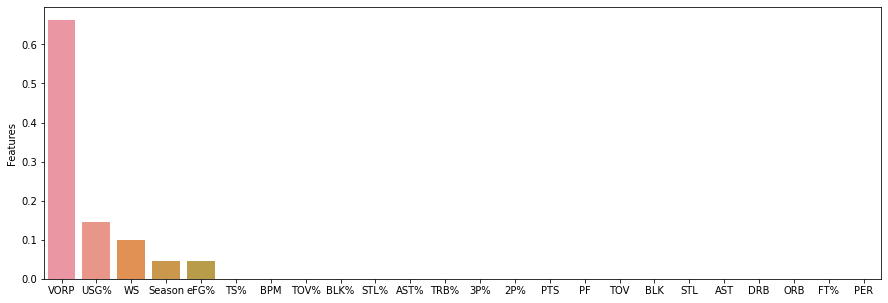

In [25]:
# df = full_nba_dataset.loc[(nba_dataset['Season'] == 2020),['Player','Share','Season']]
# df['Pred'] = pred.tolist()
# df = df.sort_values(by='Share', ascending=False)
# df.to_csv("2020_pred.csv")

X = nba_dataset.drop(['Share'], axis=1)
y = nba_dataset['Share']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

model.fit(X_train, y_train)
features_importance = pd.DataFrame(model.feature_importances_, X_train.columns)
features_importance = features_importance.sort_values(by=0, ascending=False)

rows_to_drop = list()
for item in features_importance.index:
    if features_importance.at[item,0] <= 0:
        rows_to_drop.append(item)

top_features = features_importance.drop(rows_to_drop)
display(top_features)

median = (dict(features_importance.sum(axis = 0, skipna = True))[0]) / len(features_importance.index) 
print(median) 

print(features_importance[0].quantile(0.25))

plt.figure(figsize=(15, 5))
ax = sns.barplot(x=features_importance.index, y=features_importance[0])
# ax.tick_params(axis='x', rotation=90)
ax.set_ylabel('Features')

Gonna use only the first 5 features. Importance >= 0,05.

<Figure size 2160x1800 with 0 Axes>

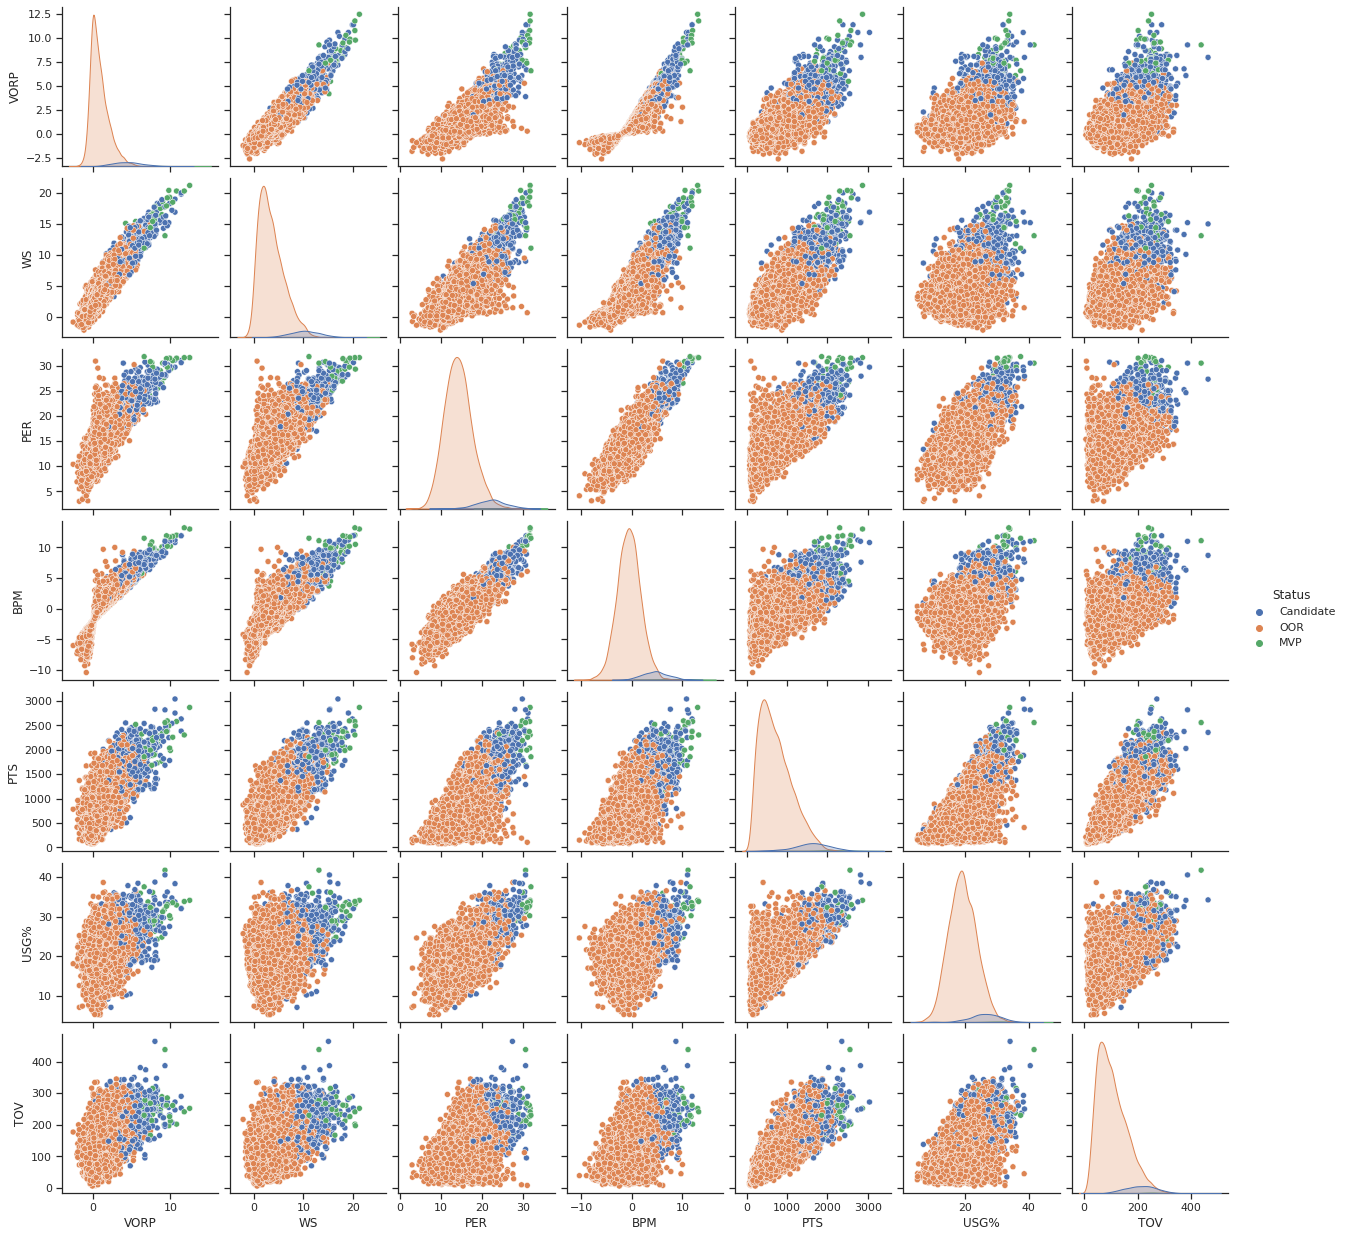

In [26]:
plt.figure(figsize=(30, 25)) 
sns.set_theme(style="ticks")
df = full_nba_dataset[['VORP','WS','PER','BPM','PTS','USG%','TOV','Status']]
sns.pairplot(df, hue="Status")

3P%	0.018766
DRB	0.018592
TS%	0.017796
AST	0.016651
TOV%	0.016171
AST%	0.015202
STL	0.014527
eFG%	0.014288
TRB%	0.014069
ORB	0.013704
STL%	0.013133
2P%	0.012645
BLK	0.012509
BLK%	0.010437

In [27]:
nba_dataset = full_nba_dataset[['VORP','WS','PER','BPM','PTS','USG%','TOV','Season','Share']]

1981 >> Fail | 2 from de top3 correct | ['Kareem Abdul-Jabbar', 'Julius Erving'] |


Player Pos  Age    3P%    2P%   eFG%    FT%  ORB  DRB  AST  \
82        Julius Erving  SF   30  0.222  0.525  0.522  0.787  244  413  364   
0   Kareem Abdul-Jabbar   C   33  0.000  0.574  0.574  0.766  197  624  272   

    ...  BLK%  TOV%  USG%    WS  BPM  VORP  Share     Status  Season  \
82  ...   2.8  13.1  28.4  13.8  7.5   6.9  0.658        MVP    1981   
0   ...   4.0  12.8  26.3  14.3  6.1   6.1  0.414  Candidate    1981   

        Label  
82    Correct  
0   Predicted  

[2 rows x 30 columns]

1982 >> Success | 3 from de top3 correct | ['Moses Malone', 'Julius Erving', 'Larry Bird'] |


Empty DataFrame
Columns: []
Index: []

1983 >> Success | 3 from de top3 correct | ['Moses Malone', 'Larry Bird', 'Magic Johnson'] |


Empty DataFrame
Columns: []
Index: []

1984 >> Success | 1 from de top3 correct | ['Larry Bird'] |


Empty DataFrame
Columns: []
Index: []

1985 >> Success | 2 from de top3 correct | ['Larry Bird', 'Magic Johnson'] |


Empty DataFrame
Columns: []
Index: []

1986 >> Success | 1 from de top3 correct | ['Larry Bird'] |


Empty DataFrame
Columns: []
Index: []

1987 >> Fail | 3 from de top3 correct | ['Larry Bird', 'Michael Jordan', 'Magic Johnson'] |


Player Pos  Age    3P%    2P%   eFG%    FT%  ORB  DRB  AST  ...  \
132  Magic Johnson  PG   27  0.205  0.532  0.525  0.848  122  382  977  ...   
21      Larry Bird  SF   30  0.400  0.547  0.555  0.910  124  558  566  ...   

     BLK%  TOV%  USG%    WS  BPM  VORP  Share     Status  Season      Label  
132   0.7  15.9  26.3  15.9  8.8   8.0  0.940        MVP    1987    Correct  
21    1.3  12.4  27.5  15.2  9.4   8.6  0.347  Candidate    1987  Predicted  

[2 rows x 30 columns]

1988 >> Success | 2 from de top3 correct | ['Michael Jordan', 'Larry Bird'] |


Empty DataFrame
Columns: []
Index: []

1989 >> Fail | 2 from de top3 correct | ['Michael Jordan', 'Magic Johnson'] |


Player Pos  Age    3P%    2P%   eFG%    FT%  ORB  DRB  AST  ...  \
153   Magic Johnson  PG   29  0.314  0.548  0.535  0.911  111  496  988  ...   
162  Michael Jordan  SG   25  0.276  0.553  0.546  0.850  149  503  650  ...   

     BLK%  TOV%  USG%    WS   BPM  VORP  Share     Status  Season      Label  
153   0.4  18.4  24.3  16.1   9.4   8.3  0.782        MVP    1989    Correct  
162   1.2  11.9  32.1  19.8  11.9  11.4  0.704  Candidate    1989  Predicted  

[2 rows x 30 columns]

1990 >> Fail | 3 from de top3 correct | ['Michael Jordan', 'Magic Johnson', 'Charles Barkley'] |


Player Pos  Age    3P%    2P%   eFG%    FT%  ORB  DRB  AST  ...  \
160   Magic Johnson  PG   30  0.384  0.510  0.526  0.890  128  394  907  ...   
168  Michael Jordan  SG   26  0.376  0.548  0.550  0.848  143  422  519  ...   

     BLK%  TOV%  USG%    WS   BPM  VORP  Share     Status  Season      Label  
160   0.7  16.9  24.8  16.5  10.1   8.9  0.691        MVP    1990    Correct  
168   1.1   9.8  33.7  19.0  11.2  10.6  0.613  Candidate    1990  Predicted  

[2 rows x 30 columns]

1991 >> Success | 3 from de top3 correct | ['Michael Jordan', 'David Robinson', 'Magic Johnson'] |


Empty DataFrame
Columns: []
Index: []

1992 >> Success | 1 from de top3 correct | ['Michael Jordan'] |


Empty DataFrame
Columns: []
Index: []

1993 >> Fail | 2 from de top3 correct | ['Michael Jordan', 'Hakeem Olajuwon'] |


Player Pos  Age    3P%    2P%   eFG%    FT%  ORB  DRB  AST  ...  \
23   Charles Barkley  PF   29  0.305  0.561  0.545  0.765  237  691  385  ...   
176   Michael Jordan  SG   29  0.352  0.514  0.515  0.837  135  387  428  ...   

     BLK%  TOV%  USG%    WS   BPM  VORP  Share     Status  Season      Label  
23    1.6  12.5  26.9  14.4   7.8   7.1  0.852        MVP    1993    Correct  
176   1.3   8.4  34.7  17.2  11.2  10.2  0.577  Candidate    1993  Predicted  

[2 rows x 30 columns]

1994 >> Fail | 2 from de top3 correct | ['David Robinson', 'Scottie Pippen'] |


Player Pos  Age    3P%    2P%  eFG%    FT%  ORB  DRB  AST  ...  \
274  Hakeem Olajuwon   C   31  0.421  0.529  0.53  0.716  229  726  287  ...   
312   David Robinson   C   28  0.345  0.510  0.51  0.749  241  614  381  ...   

     BLK%  TOV%  USG%    WS   BPM  VORP  Share     Status  Season      Label  
274   5.7  12.3  29.8  14.3   6.8   7.3  0.880        MVP    1994    Correct  
312   5.4  10.9  32.0  20.0  11.9  11.4  0.723  Candidate    1994  Predicted  

[2 rows x 30 columns]

1995 >> Success | 1 from de top3 correct | ['David Robinson'] |


Empty DataFrame
Columns: []
Index: []

1996 >> Success | 2 from de top3 correct | ['Michael Jordan', 'David Robinson'] |


Empty DataFrame
Columns: []
Index: []

1997 >> Success | 2 from de top3 correct | ['Karl Malone', 'Michael Jordan'] |


Empty DataFrame
Columns: []
Index: []

1998 >> Success | 2 from de top3 correct | ['Michael Jordan', 'Karl Malone'] |


Empty DataFrame
Columns: []
Index: []

1999 >> Fail | 0 from de top3 correct | [] |


Player Pos  Age    3P%    2P%   eFG%    FT%  ORB  DRB  AST  \
230        Karl Malone  PF   35  0.000  0.494  0.493  0.788  107  356  201   
0    Tariq Abdul-Wahad  SG   24  0.286  0.443  0.442  0.691   72  114   50   

     ...  BLK%  TOV%  USG%   WS  BPM  VORP  Share  Status  Season      Label  
230  ...   1.2  13.8  30.5  9.6  6.7   4.0  0.701     MVP    1999    Correct  
0    ...   0.8  13.0  19.0  1.4 -3.0  -0.3  0.000     OOR    1999  Predicted  

[2 rows x 30 columns]

2000 >> Success | 1 from de top3 correct | ["Shaquille O'Neal"] |


Empty DataFrame
Columns: []
Index: []

2001 >> Fail | 0 from de top3 correct | [] |


Player Pos  Age    3P%    2P%   eFG%    FT%  ORB  DRB  AST  ...  \
185  Allen Iverson  SG   25  0.320  0.441  0.447  0.814   50  223  325  ...   
64    Vince Carter  SF   24  0.408  0.477  0.509  0.765  176  240  291  ...   

     BLK%  TOV%  USG%    WS  BPM  VORP  Share     Status  Season      Label  
185   0.5  10.0  35.9  11.8  6.1   6.1  0.904        MVP    2001    Correct  
64    1.9   8.2  30.7  12.9  7.6   7.2  0.006  Candidate    2001  Predicted  

[2 rows x 30 columns]

2002 >> Success | 2 from de top3 correct | ['Tim Duncan', "Shaquille O'Neal"] |


Empty DataFrame
Columns: []
Index: []

2003 >> Fail | 1 from de top3 correct | ['Kevin Garnett'] |


Player Pos  Age    3P%    2P%   eFG%    FT%  ORB  DRB  AST  ...  \
108     Tim Duncan  PF   26  0.273  0.517  0.515  0.710  259  784  316  ...   
247  Tracy McGrady  SG   23  0.386  0.481  0.505  0.793  121  367  411  ...   

     BLK%  TOV%  USG%    WS   BPM  VORP  Share     Status  Season      Label  
108   5.2  12.9  28.0  16.5   7.6   7.7  0.808        MVP    2003    Correct  
247   1.5   8.4  35.2  16.1  10.5   9.3  0.359  Candidate    2003  Predicted  

[2 rows x 30 columns]

2004 >> Success | 2 from de top3 correct | ['Kevin Garnett', 'Tim Duncan'] |


Empty DataFrame
Columns: []
Index: []

2005 >> Fail | 1 from de top3 correct | ['Dirk Nowitzki'] |


Player Pos  Age    3P%    2P%   eFG%    FT%  ORB  DRB  AST  ...  \
301     Steve Nash  PG   30  0.431  0.526  0.557  0.887   57  192  861  ...   
147  Kevin Garnett  PF   28  0.240  0.507  0.504  0.811  247  861  466  ...   

     BLK%  TOV%  USG%    WS  BPM  VORP  Share     Status  Season      Label  
301   0.2  20.3  20.5  10.9  4.7   4.4  0.839        MVP    2005    Correct  
147   2.6  12.2  27.1  16.1  9.5   9.1  0.012  Candidate    2005  Predicted  

[2 rows x 30 columns]

2006 >> Fail | 2 from de top3 correct | ['LeBron James', 'Dirk Nowitzki'] |


Player Pos  Age    3P%    2P%   eFG%    FT%  ORB  DRB  AST  ...  \
294    Steve Nash  PG   31  0.439  0.548  0.583  0.921   47  286  826  ...   
206  LeBron James  SF   21  0.335  0.518  0.515  0.738   75  481  521  ...   

     BLK%  TOV%  USG%    WS  BPM  VORP  Share     Status  Season      Label  
294   0.3  19.0  23.3  12.4  5.0   4.9  0.739        MVP    2006    Correct  
206   1.5  10.7  33.6  16.3  9.1   9.4  0.550  Candidate    2006  Predicted  

[2 rows x 30 columns]

2007 >> Success | 2 from de top3 correct | ['Dirk Nowitzki', 'Kobe Bryant'] |


Empty DataFrame
Columns: []
Index: []

2008 >> Fail | 2 from de top3 correct | ['Chris Paul', 'Kobe Bryant'] |


Player Pos  Age    3P%    2P%   eFG%    FT%  ORB  DRB  AST  ...  \
65    Kobe Bryant  SG   29  0.361  0.490  0.503  0.840   94  423  441  ...   
210  LeBron James  SF   23  0.315  0.531  0.518  0.712  133  459  539  ...   

     BLK%  TOV%  USG%    WS   BPM  VORP  Share     Status  Season      Label  
65    0.9  11.3  31.4  13.8   5.8   6.3  0.873        MVP    2008    Correct  
210   2.1  11.4  33.5  15.2  10.9   9.8  0.348  Candidate    2008  Predicted  

[2 rows x 30 columns]

2009 >> Success | 2 from de top3 correct | ['LeBron James', 'Dwyane Wade'] |


Empty DataFrame
Columns: []
Index: []

2010 >> Success | 2 from de top3 correct | ['LeBron James', 'Kevin Durant'] |


Empty DataFrame
Columns: []
Index: []

2011 >> Fail | 2 from de top3 correct | ['LeBron James', 'Derrick Rose'] |


Player Pos  Age    3P%    2P%   eFG%    FT%  ORB  DRB  AST  ...  \
355  Derrick Rose  PG   22  0.332  0.481  0.485  0.858   81  249  623  ...   
225  LeBron James  SF   26  0.330  0.552  0.541  0.759   80  510  554  ...   

     BLK%  TOV%  USG%    WS  BPM  VORP  Share     Status  Season      Label  
355   1.3  13.1  32.2  13.1  6.8   6.7  0.977        MVP    2011    Correct  
225   1.3  13.8  31.5  15.6  8.1   7.8  0.431  Candidate    2011  Predicted  

[2 rows x 30 columns]

2012 >> Success | 2 from de top3 correct | ['LeBron James', 'Chris Paul'] |


Empty DataFrame
Columns: []
Index: []

2013 >> Fail | 2 from de top3 correct | ['Kevin Durant', 'LeBron James'] |


Player Pos  Age    3P%    2P%   eFG%    FT%  ORB  DRB  AST  ...  \
211  LeBron James  PF   28  0.406  0.602  0.603  0.753   97  513  551  ...   
119  Kevin Durant  SF   24  0.416  0.539  0.559  0.905   46  594  374  ...   

     BLK%  TOV%  USG%    WS   BPM  VORP  Share     Status  Season      Label  
211   1.9  12.4  30.2  19.3  11.7   9.9  0.998        MVP    2013    Correct  
119   2.6  13.7  29.8  18.9   9.3   8.9  0.632  Candidate    2013  Predicted  

[2 rows x 30 columns]

2014 >> Fail | 2 from de top3 correct | ['LeBron James', 'Kevin Durant'] |


Player Pos  Age    3P%    2P%  eFG%    FT%  ORB  DRB  AST  ...  \
133  Kevin Durant  SF   25  0.391  0.549  0.56  0.873   58  540  445  ...   
225  LeBron James  PF   29  0.379  0.622  0.61  0.750   81  452  488  ...   

     BLK%  TOV%  USG%    WS   BPM  VORP  Share     Status  Season      Label  
133   1.5  12.2  33.0  19.2  10.2   9.6  0.986        MVP    2014    Correct  
225   0.8  14.4  31.0  15.9   8.8   7.9  0.713  Candidate    2014  Predicted  

[2 rows x 30 columns]

2015 >> Success | 2 from de top3 correct | ['Stephen Curry', 'James Harden'] |


Empty DataFrame
Columns: []
Index: []

2016 >> Success | 2 from de top3 correct | ['Stephen Curry', 'Kawhi Leonard'] |


Empty DataFrame
Columns: []
Index: []

2017 >> Fail | 1 from de top3 correct | ['James Harden'] |


Player Pos  Age    3P%    2P%   eFG%    FT%  ORB  DRB  AST  \
457  Russell Westbrook  PG   28  0.343  0.459  0.476  0.845  137  727  840   
171       James Harden  PG   27  0.347  0.530  0.525  0.847   95  564  907   

     ...  BLK%  TOV%  USG%    WS   BPM  VORP  Share     Status  Season  \
457  ...   0.9  15.9  41.7  13.1  11.1   9.3  0.879        MVP    2017   
171  ...   1.0  19.5  34.2  15.0   8.7   8.0  0.746  Candidate    2017   

         Label  
457    Correct  
171  Predicted  

[2 rows x 30 columns]

2018 >> Success | 2 from de top3 correct | ['James Harden', 'LeBron James'] |


Empty DataFrame
Columns: []
Index: []

2019 >> Fail | 2 from de top3 correct | ['James Harden', 'Giannis Antetokounmpo'] |


Player Pos  Age    3P%    2P%   eFG%    FT%  ORB  DRB  \
17   Giannis Antetokounmpo  PF   24  0.256  0.641  0.599  0.729  159  739   
205           James Harden  PG   29  0.368  0.528  0.541  0.879   66  452   

     AST  ...  BLK%  TOV%  USG%    WS   BPM  VORP  Share     Status  Season  \
17   424  ...   3.9  14.8  32.3  14.4  10.4   7.4  0.932        MVP    2019   
205  586  ...   1.7  14.5  40.5  15.2  11.0   9.3  0.768  Candidate    2019   

         Label  
17     Correct  
205  Predicted  

[2 rows x 30 columns]

2020 >> Fail | 3 from de top3 correct | ['LeBron James', 'Giannis Antetokounmpo', 'James Harden'] |


Player Pos  Age    3P%    2P%   eFG%    FT%  ORB  DRB  \
12   Giannis Antetokounmpo  PF   25  0.304  0.631  0.589  0.633  140  716   
249           LeBron James  PG   35  0.348  0.564  0.550  0.693   66  459   

     AST  ...  BLK%  TOV%  USG%    WS   BPM  VORP  Share     Status  Season  \
12   354  ...   3.0  13.2  37.5  11.1  11.5   6.6  0.952        MVP    2020   
249  684  ...   1.4  15.1  31.5   9.8   8.4   6.1  0.746  Candidate    2020   

         Label  
12     Correct  
249  Predicted  

[2 rows x 30 columns]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10673 entries, 0 to 529
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   VORP    10673 non-null  float64
 1   WS      10673 non-null  float64
 2   PER     10673 non-null  float64
 3   BPM     10673 non-null  float64
 4   PTS     10673 non-null  int64  
 5   USG%    10673 non-null  float64
 6   TOV     10673 non-null  int64  
dtypes: float64(5), int64(2)
memory usage: 667.1 KB
None


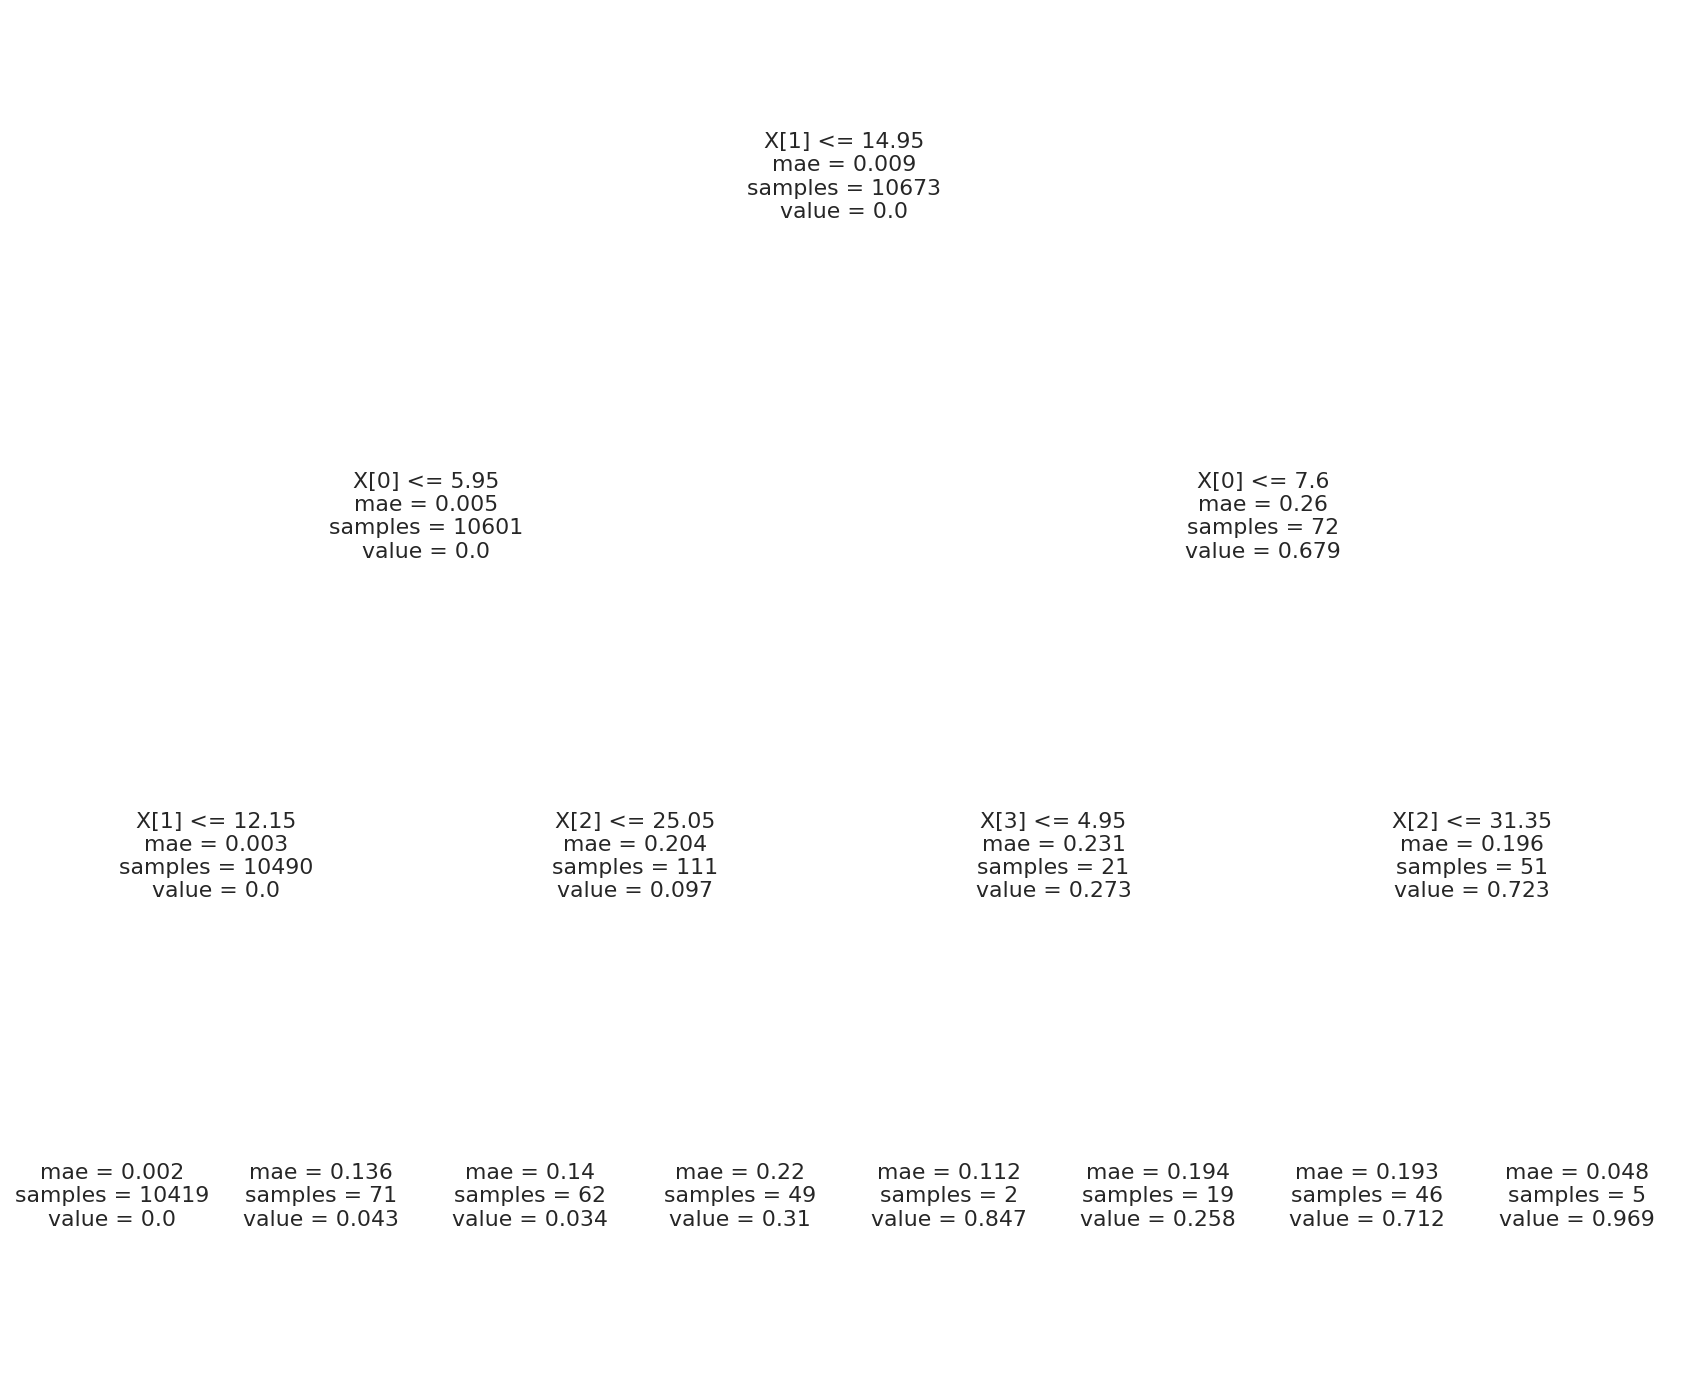

GLOBAL_SUCCESS_RATE : 55.00000000000001%
GLOBAL_SUCCESS_RATE_TOP3 : 61.66666666666667%
Time elapsed: 27.602927446365356


In [28]:
nro_of_corrects = 0
nro_of_top3_corrects = 0
iterations = 1

file = open("output.txt","w")

t1 = time.time()

for season in np.arange(1981,2021,1):
    
    text = f'{season} >> '

    y_train = nba_dataset.loc[(nba_dataset['Season'] != season),['Share']]
    y_train = np.ravel(y_train)
    y_test = nba_dataset.loc[(nba_dataset['Season'] == season),['Share']]
    y_test = np.ravel(y_test)

    X_train = nba_dataset.loc[(nba_dataset['Season'] != season),:].drop(['Share','Season'], axis=1)
    X_test = nba_dataset.loc[(nba_dataset['Season'] == season),:].drop(['Share','Season'], axis=1)

    players_rank = dict()
    df = full_nba_dataset.loc[(nba_dataset['Season'] == season),['Player','Share','Season']]
    df_truth = df.sort_values(by='Share', ascending=False)

    for i in range(iterations):

        model.fit(X_train, y_train)
        pred = model.predict(X_test)
    #     print(model_measure(y_test, pred))

        df['Pred'] = pred.tolist()
        df_pred = df.drop(['Share'],axis=1).sort_values(by='Pred', ascending=False)

        for j in range(5):
            if df_pred.iat[j,0] in players_rank.keys():
                players_rank[df_pred.iat[j,0]] += (10-(j*2))
            else:
                players_rank[df_pred.iat[j,0]] = (10-(j*2))

    players_columns = list(players_rank.keys())
    votes_columns = []

    for k in players_columns:
        votes_columns.append(players_rank[k])

    data = dict()
    data['Player'] = players_columns
    data['Season'] = season
    data['Pred'] = votes_columns

    df_pred_final = pd.DataFrame(data)
    df_pred_final = df_pred_final.sort_values(by='Pred', ascending=False)
    df_pred_final.to_csv(f"./predictions/{season}_pred.csv")

    pred_top3 = list(df_pred_final['Player'].iloc[:3])
    top3 = list(df_truth['Player'].iloc[:3]) 
    top3_success = list()
    
    for z in pred_top3:
        if z in top3:
            top3_success.append(z)

    df_comp = pd.DataFrame()
    
    if pred_top3[0] == top3[0]:
        text += 'Success | '
        nro_of_corrects += 1
    else:
        text += 'Fail | '
        df_comp = full_nba_dataset.loc[(nba_dataset['Season'] == season) & (full_nba_dataset['Player'] == top3[0]) ,:]
        df_comp = df_comp.append(full_nba_dataset.loc[(nba_dataset['Season'] == season) & (full_nba_dataset['Player'] == pred_top3[0]) ,:])
        df_comp['Label'] = ['Correct','Predicted']
        df_comp.to_csv('./misses/{}_miss.csv'.format(season),index=False)
    
    

    text += f'{len(top3_success)} from de top3 correct | {top3_success} |'
    nro_of_top3_corrects += len(top3_success)

    print(text)
    file.write(str(text))
    display(df_comp)


print(X_train.info())    
plt.figure(figsize=(30, 25))
tree.plot_tree(model)  
plt.show()

text = f"GLOBAL_SUCCESS_RATE : {100*(nro_of_corrects/40)}%\nGLOBAL_SUCCESS_RATE_TOP3 : {100*(nro_of_top3_corrects/120)}%"
print(text)
file.write(str(text))
file.close()
t2 = time.time()

print('Time elapsed: {}'.format(t2-t1))

In [29]:
df_clear = pd.DataFrame()
feature_list = ['VORP','WS','PER','BPM','PTS']
feature_values = []

for feature in feature_list:
    for season in np.arange(1981,2021,1):
        df = full_nba_dataset.loc[(full_nba_dataset['Season'] == season), ['Season','Player',feature,'Status']]
        df = df.sort_values(by=feature, ascending= False)

        if season == 1981:
            df_clear = df.iloc[:1]
        else:
            df_clear = df_clear.append(df.iloc[:1])

    df = df_clear.groupby('Status').size().reset_index(name='counts')
    df = df.sort_values(by='Status')

    importance = (df.iat[1,1]/(df.iat[1,1]+df.iat[0,1]))*100
    formated_importance = "{:.2f}%"
    feature_values.append(formated_importance.format(importance))

dfts = pd.DataFrame()
dfts['Features'] = feature_list
dfts['Importance'] = feature_values
display(dfts.sort_values(by='Importance',ascending=False)) 


Features Importance
1       WS     55.00%
2      PER     52.63%
0     VORP     50.00%
3      BPM     50.00%
4      PTS     25.00%